Рассмотрим приложение по доставке продуктов. Команда внедрила в приложение умную систему рекомендации товаров – предполагается, что такая система поможет пользователям эффективнее работать с приложением и лучше находить необходимые товары.

Чтобы проверить эффективность системы рекомендаций, был проведен АБ-тест. В группе 1 оказались пользователи с новой системой рекомендаций, в группе 0 пользователи со старой версией приложения, где нет рекомендации товаров.

Наша задача – оценить, смогла ли новая система рекомендаций принести пользу бизнесу и пользователям приложения. Для этого нужно выбрать метрики, которые отвечают за качество сервиса, и статистически сравнить эти метрики в двух группах.

Результат работы – аналитическое заключение с ответом на вопрос, стоит ли включать новую систему рекомендаций на всех пользователей.

In [ ]:
import pandas as pd
import numpy as np

import seaborn as sns
import matplotlib.pyplot as plt

%matplotlib inline
from scipy.stats import iqr
import scipy
from scipy import stats
import pingouin as pg
from scipy.stats import chi2_contingency

Загрузим датасет с историей заказов пользователей, в этой таблице есть информация о том, какие заказы создавали и отменяли пользователи

In [70]:
users = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-artemov/Statistic/Lesson_10/ab_users_data.csv')

In [71]:
users

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19.000000,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21.000000,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27.000000,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56.000000,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37.000000,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03.000000,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05.000000,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27.000000,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06.000000,2022-09-08,0


In [72]:
users.dtypes

user_id      int64
order_id     int64
action      object
time        object
date        object
group        int64
dtype: object

In [73]:
users.time = pd.to_datetime(users.time)
users.date = pd.to_datetime(users.date)

Orders - подробная информация о составе заказа, тут для каждого заказа есть список id тех продуктов, которые были включены в заказ

In [74]:
orders = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-artemov/Statistic/Lesson_10/ab_orders.csv')

In [75]:
orders

,order_id,creation_time,product_ids
0,1255,2022-08-26 00:00:19.000000,"{75, 22, 53, 84}"
1,1256,2022-08-26 00:02:21.000000,"{56, 76, 39}"
2,1257,2022-08-26 00:02:27.000000,"{76, 34, 41, 38}"
3,1258,2022-08-26 00:02:56.000000,"{74, 6}"
4,1259,2022-08-26 00:03:37.000000,"{20, 45, 67, 26}"
...,...,...,...
4118,59422,2022-09-08 23:13:03.000000,"{84, 8, 24}"
4119,59439,2022-09-08 23:18:05.000000,"{9, 25, 75, 30, 6}"
4120,59464,2022-09-08 23:22:27.000000,"{60, 41, 46}"
4121,59487,2022-09-08 23:29:06.000000,"{9, 62, 77}"


In [76]:
orders.dtypes

order_id          int64
creation_time    object
product_ids      object
dtype: object

In [77]:
orders.creation_time = pd.to_datetime(orders.creation_time)

Products - таблица с подробной информацией о продуктах, их название и стоимость

In [78]:
products = pd.read_csv('/mnt/HC_Volume_18315164/home-jupyter/jupyter-p-artemov/Statistic/Lesson_10/ab_products.csv')

In [79]:
products

,product_id,name,price
0,1,сахар,150.0
1,2,чай зеленый в пакетиках,50.0
2,3,вода негазированная,80.4
3,4,леденцы,45.5
4,5,кофе 3 в 1,15.0
...,...,...,...
82,83,вафли,55.0
83,84,мандарины,90.4
84,85,варенье,200.3
85,86,кофе холодный,70.3


In [80]:
products.dtypes

product_id      int64
name           object
price         float64
dtype: object

Выберем первую метрику - пропорция отмененных заказов

In [81]:
users

,user_id,order_id,action,time,date,group
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0
3,966,1258,create_order,2022-08-26 00:02:56,2022-08-26,0
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1
...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0


In [82]:
df_1 = pd.crosstab(users.group, users.action)

In [83]:
df_1

action,cancel_order,create_order
group,,
0,82,1609
1,132,2514


Сформулируем H0 : взаимосвязи между количеством заказов и группой отсутствует
Так как p_value > 0.05 - мы не можем отклонить H0.

In [84]:
scipy.stats.chi2_contingency(df_1)

(0.018211165651942023,
 0.8926523935841298,
 1,
 array([[  83.43878257, 1607.56121743],
        [ 130.56121743, 2515.43878257]]))

Посмотрим метрику - количество созданных заказов.
Для этого посчитаем ожидаемое количество заказов для обеих групп, если бы они были одинаковыми

In [85]:
df_1["wait"] = df_1.create_order.sum()/2

In [86]:
df_1

action,cancel_order,create_order,wait
group,,,
0,82,1609,2061.5
1,132,2514,2061.5


Сформулируем Н0: Количество заказов в тестовой группе не отличается от ожидаемого
Применим Хи-квадрат для одной случайной величины. 
Как результат - получим p-value < 0.05, ,следовательно можем отклонить Н0 и утверждать, что в группе 1 количество заказов стат. значимо увеличилось по сравнению с группой 0

In [87]:
scipy.stats.chisquare(df_1.wait, f_exp = df_1.create_order)

Power_divergenceResult(statistic=208.7032367035465, pvalue=2.6350379816572005e-47)

Из вышеуказанного можем сделать вывод, что количество заказов в 1-ой группе стат.значимо больше количетсва заказов в 0-ой группе. При этом соотношение отмененные/созданные заказы не увеличилось. 
Следовательно 

Возьмем за следующую метрику сумму вырученную с обеих групп

In [88]:
orders['products'] = orders.product_ids.apply(lambda x: x[1:-1].split(', '))

In [89]:
orders

,order_id,creation_time,product_ids,products
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}","[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}","[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}","[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"{74, 6}","[74, 6]"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}","[20, 45, 67, 26]"
...,...,...,...,...
4118,59422,2022-09-08 23:13:03,"{84, 8, 24}","[84, 8, 24]"
4119,59439,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}","[9, 25, 75, 30, 6]"
4120,59464,2022-09-08 23:22:27,"{60, 41, 46}","[60, 41, 46]"
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}","[9, 62, 77]"


In [90]:
orders.products = orders.products.apply(lambda x:[int(item) for item in x])

In [91]:
orders

,order_id,creation_time,product_ids,products
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}","[75, 22, 53, 84]"
1,1256,2022-08-26 00:02:21,"{56, 76, 39}","[56, 76, 39]"
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}","[76, 34, 41, 38]"
3,1258,2022-08-26 00:02:56,"{74, 6}","[74, 6]"
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}","[20, 45, 67, 26]"
...,...,...,...,...
4118,59422,2022-09-08 23:13:03,"{84, 8, 24}","[84, 8, 24]"
4119,59439,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}","[9, 25, 75, 30, 6]"
4120,59464,2022-09-08 23:22:27,"{60, 41, 46}","[60, 41, 46]"
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}","[9, 62, 77]"


In [92]:
orders['price'] = 0

In [93]:
for i in range(len(orders)):
    for j in range(len(products)):
        if products.product_id[j] in orders.products[i]:
            orders.price[i] += products.price[j]
        else:
            continue

/opt/tljh/user/lib/python3.7/site-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.


In [94]:
orders_price = orders[['order_id', 'price']]

In [95]:
orders_price

,order_id,price
0,1255,408
1,1256,250
2,1257,309
3,1258,85
4,1259,228
...,...,...
4118,59422,240
4119,59439,518
4120,59464,185
4121,59487,501


In [96]:
users_price = users.merge(orders_price, on = 'order_id', how = 'left')

Не будем учитывать заказы, которые по итогу были отменены, так как по ним мы не получим прибыль 

In [97]:
users_price = users_price.drop_duplicates(subset = "order_id", keep=False)

In [98]:
users_price

,user_id,order_id,action,time,date,group,price
0,964,1255,create_order,2022-08-26 00:00:19,2022-08-26,0,408
1,965,1256,create_order,2022-08-26 00:02:21,2022-08-26,1,250
2,964,1257,create_order,2022-08-26 00:02:27,2022-08-26,0,309
4,967,1259,create_order,2022-08-26 00:03:37,2022-08-26,1,228
5,968,1261,create_order,2022-08-26 00:05:35,2022-08-26,0,430
...,...,...,...,...,...,...,...
4332,990,59422,create_order,2022-09-08 23:13:03,2022-09-08,1,240
4333,1418,59439,create_order,2022-09-08 23:18:05,2022-09-08,1,518
4334,1605,59464,create_order,2022-09-08 23:22:27,2022-09-08,0,185
4335,1461,59487,create_order,2022-09-08 23:29:06,2022-09-08,0,501


In [99]:
users_price_sum = users_price.groupby("group").agg({"price":"sum"})

Построим распределение цен заказов в первой группе

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


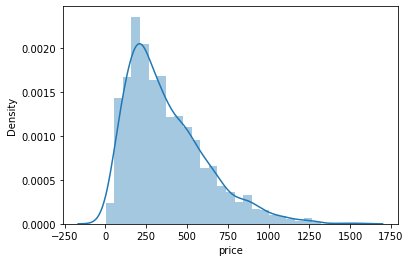

In [100]:
sns.distplot(users_price.query("group == 0").price)

Проверим распределение на нормальность тестом Шапиро-Уилка
Получили p_value<0.05, что дает нам возможность отклонить нулевую гипотезу о нормальности распределения

In [101]:
from scipy import stats
stats.shapiro(users_price.query("group == 0").price)

ShapiroResult(statistic=0.9196389317512512, pvalue=9.236931421046234e-28)

Построим распределение цен заказов в первой группе 

/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


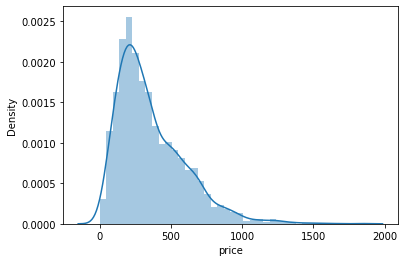

In [102]:
sns.distplot(users_price.query("group == 1").price)

Как и для количества заказов посмотрим как распределялась бы сумма полученная от группа ожидаемо 

In [103]:
users_price_sum["wait_price"] = users_price_sum.price.sum()/2

In [104]:
users_price_sum

,price,wait_price
group,,
0,571851,715771.5
1,859692,715771.5


Сформулируем следующую Н0: Сумма выручки в группе 1 не отличается от ожидаемой 
Проведя исследование методом Хи-квадрат получим p-value < 0.05 , следовательно сумма выручки в 1 группе стат.значимо отличается от выручки в группе 0 

In [105]:
scipy.stats.chisquare(users_price_sum.wait_price, f_exp = users_price_sum.price)

Power_divergenceResult(statistic=60314.80744868689, pvalue=0.0)

Проверим метрику - количество продуктов в заказе 

In [106]:
orders

,order_id,creation_time,product_ids,products,price
0,1255,2022-08-26 00:00:19,"{75, 22, 53, 84}","[75, 22, 53, 84]",408
1,1256,2022-08-26 00:02:21,"{56, 76, 39}","[56, 76, 39]",250
2,1257,2022-08-26 00:02:27,"{76, 34, 41, 38}","[76, 34, 41, 38]",309
3,1258,2022-08-26 00:02:56,"{74, 6}","[74, 6]",85
4,1259,2022-08-26 00:03:37,"{20, 45, 67, 26}","[20, 45, 67, 26]",228
...,...,...,...,...,...
4118,59422,2022-09-08 23:13:03,"{84, 8, 24}","[84, 8, 24]",240
4119,59439,2022-09-08 23:18:05,"{9, 25, 75, 30, 6}","[9, 25, 75, 30, 6]",518
4120,59464,2022-09-08 23:22:27,"{60, 41, 46}","[60, 41, 46]",185
4121,59487,2022-09-08 23:29:06,"{9, 62, 77}","[9, 62, 77]",501


In [107]:
orders["count_products"]=orders.products.apply(lambda x: len(x))

In [108]:
orders_count_products = orders[["order_id", "count_products"]]

In [109]:
group_count_products = users.merge(orders_count_products, on = 'order_id', how = 'left').drop_duplicates(subset = "order_id", keep=False)[["group", "count_products"]]

In [110]:
group_count_products.groupby("group").agg({"count_products":"sum"})

,count_products
group,
0,5103
1,7980


/opt/tljh/user/lib/python3.7/site-packages/seaborn/distributions.py:2557: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


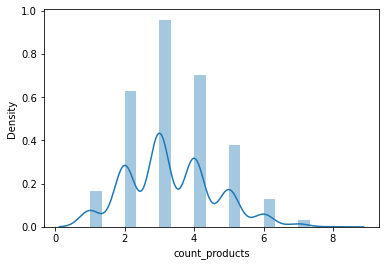

In [111]:
sns.distplot(group_count_products.query("group==0").count_products)

Распределение количества покупок не является нормальным

In [112]:
stats.shapiro(group_count_products.query("group==0").count_products)

ShapiroResult(statistic=0.9359715580940247, pvalue=4.123595846567559e-25)

Сформулируем Н0 : среднее количество товаров по заказу в 0 группе значимо не отличается от аналогичного показателя в группе 1
Воспользуемся критерием Манна-Уитни и получим p_value>0.05, что не позволяет отклонить Н0

In [113]:
stats.mannwhitneyu(group_count_products.query("group==0").count_products, group_count_products.query("group==1").count_products)

MannwhitneyuResult(statistic=1806128.0, pvalue=0.7083277937581569)

Аналогичным образом, как с заказами и выручкой, посмотрим изменилось ли общее количество проданных продуктов 
Н0: Количество проданных продуктов не отличается от ожидаемого

In [114]:
group_count_product = group_count_products.groupby("group").agg({"count_products":"sum"})

In [115]:
group_count_product["wait_count_products"] = group_count_product.count_products.sum()/2

Получаем p-value < 0.05, следовательно количество проданных продуктов пользователям из 1-ой группы стат. значимо больше количества продуктов купленных пользователям 0-ой группы 

In [116]:
scipy.stats.chisquare(group_count_product.wait_count_products, f_exp = group_count_product.count_products)

Power_divergenceResult(statistic=664.811639051332, pvalue=1.3425385375169871e-146)

Согласно анализу по проведенному А/В тесту можем сделать вывод об увеличении количества заказов (без значимого увеличения отмененных заказов) в тестируемой группе, увеличении полученной прибыли в 1-ой группе, а так же увеличении количества проданных товаров (при отсутствии увеличения среднего количества проданных товаров в заказе)

Делаем вывод о необходимости развертывания новой системы для всех пользователей 